In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, simpson
from scipy.interpolate import interp1d

from imripy import constants as c, kepler, merger_system as ms, halo, inspiral

This notebook is a quick comparison to [2002.12811](https://arxiv.org/abs/2002.12811). We define the feedback ratio and recreate their Figure 2

In [2]:
m1 = 1e3 * c.solar_mass_to_pc
m2 = 1. * c.solar_mass_to_pc

hs = ms.HostSystem(m1)

In [3]:
gw = inspiral.forces.GWLoss()

In [4]:
gamma_73 = 7./3.
gamma_32 = 3./2.

spike_73 = halo.Spike.FromSpikedNFW(halo.SpikedNFW.FromNFW(halo.NFW.FromHaloMass(1e3*m1, 20), m1, gamma_73))
spike_32 = halo.Spike.FromSpikedNFW(halo.SpikedNFW.FromNFW(halo.NFW.FromHaloMass(1e3*m1, 20), m1, gamma_32))

In [5]:
rho_spike = 226 *c.solar_mass_to_pc

gamma_73 = 7./3.
gamma_32 = 3./2.

r_spike = lambda gamma : ((3.-gamma)*0.2**(3.-gamma)*m1/2./np.pi/rho_spike)**(1./3.)

spike_73 = halo.Spike(rho_spike, r_spike(gamma_73), gamma_73, m1)
spike_32 = halo.Spike(rho_spike, r_spike(gamma_32), gamma_32, m1)

In [6]:
df_32 = inspiral.forces.DynamicalFriction(halo=spike_32, haloPhaseSpaceDescription=True, includeHigherVelocities=True,
                                             relativisticCorrections=True)
df_32_kav = inspiral.forces.DynamicalFriction(halo=spike_32, haloPhaseSpaceDescription=False, includeHigherVelocities=False,
                                             relativisticCorrections=False)
df_73 = inspiral.forces.DynamicalFriction(halo=spike_73, haloPhaseSpaceDescription=True, includeHigherVelocities=True,
                                             relativisticCorrections=True)
df_73_kav = inspiral.forces.DynamicalFriction(halo=spike_73, haloPhaseSpaceDescription=False, includeHigherVelocities=False,
                                             relativisticCorrections=False)


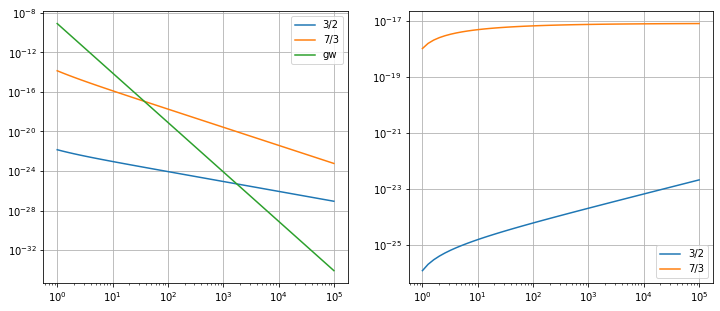

In [7]:
r_grid = np.geomspace(hs.r_isco, 1e5*hs.r_isco, 50)
fig, axs = plt.subplots(1,2, figsize=(12,5))

opt = inspiral.Classic.EvolutionOptions()
axs[0].loglog(r_grid/hs.r_isco, np.abs([df_32.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r), opt) for r in r_grid]), label='3/2')
axs[0].loglog(r_grid/hs.r_isco, np.abs([df_73.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r), opt) for r in r_grid]), label='7/3')
axs[0].loglog(r_grid/hs.r_isco, np.abs([gw.dE_dt(hs, kepler.KeplerOrbit(hs, m2, r), opt) for r in r_grid]), label='gw')
axs[0].grid(); axs[0].legend()

axs[1].loglog(r_grid/hs.r_isco, np.abs(spike_32.potentialEnergy(r_grid)), label='3/2')
axs[1].loglog(r_grid/hs.r_isco, np.abs(spike_73.potentialEnergy(r_grid)), label='7/3')
axs[1].grid(); axs[1].legend()

In [8]:
def energy_loss(hs, ev, df, opt):
    dE = np.array([df.dE_dt(hs, ev.get_kepler_orbit(i), opt) for i in range(len(ev.t))])
    return simpson(dE, x= ev.t)

In [9]:
ko = kepler.KeplerOrbit(hs, m2, 1e2*hs.r_isco)
opt_32 = inspiral.Classic.EvolutionOptions(dissipativeForces=[df_32, gw], accuracy=1e-9)
ev_32 = inspiral.Classic.Evolve(hs, ko, opt=opt_32)

Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {DynamicalFriction, GWLoss, }, accuracy = 1.0e-09
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.5932s real time


In [10]:
E0 = inspiral.Classic.E_orbit(hs, ev_32.get_kepler_orbit(0))
Efin = inspiral.Classic.E_orbit(hs, ev_32.get_kepler_orbit(-1))
DeltaE = Efin-E0
E0, Efin, DeltaE

(-3.9999999999999997e-17, -1.4999999998904995e-15, -1.4599999998904995e-15)

In [11]:
DeltaE_gw = energy_loss(hs, ev_32, gw, opt_32)
DeltaE_32 = energy_loss(hs, ev_32, df_32, opt_32)
DeltaE_gw, DeltaE_32, DeltaE_gw + DeltaE_32

(-1.4586991011550407e-15, -1.4107405727529268e-22, -1.458699242229098e-15)

In [12]:
spike_32.potentialEnergy(ko.a), spike_32.potentialEnergy(spike_32.r_spike)

(-6.269160405155965e-25, -2.8360987107687986e-21)

In [13]:
DeltaE_32/ spike_32.potentialEnergy(spike_32.r_spike)

0.04974229449053657

In [14]:
opt_73 = inspiral.Classic.EvolutionOptions(dissipativeForces=[df_73, gw])
ev_73 = inspiral.Classic.Evolve(hs, ko, t_fin=ev_32.t[-1],opt=opt_73)

Evolving from  100.0  to  1.0 r_isco   on circular orbits  with  Options: dissipative forces employed {DynamicalFriction, GWLoss, }, accuracy = 1.0e-10
A termination event occurred.
 -> Ended at 2.667e+00r_isco. Evolution took 0.7284s real time


In [15]:
E0 = inspiral.Classic.E_orbit(hs, ev_73.get_kepler_orbit(0))
Efin = inspiral.Classic.E_orbit(hs, ev_73.get_kepler_orbit(-1))
DeltaE = Efin-E0
E0, Efin, DeltaE

(-3.9999999999999997e-17, -1.499999999995331e-15, -1.459999999995331e-15)

In [16]:
DeltaE_gw = energy_loss(hs, ev_73, gw, opt_32)
DeltaE_73 = energy_loss(hs, ev_73, df_73, opt_73)
DeltaE_gw, DeltaE_73, DeltaE_gw + DeltaE_73

(-1.3725171285529786e-15, -8.722516402677071e-17, -1.4597422925797494e-15)

In [17]:
spike_73.potentialEnergy(ko.a), spike_73.potentialEnergy(ev_73.get_kepler_orbit(-1).a)

(-6.659356036881394e-18, -3.0355301148050204e-18)

In [18]:
DeltaE_73/ spike_73.potentialEnergy(ko.a)

13.098137949629534

In [19]:
def get_DE_df(hs, m2, a0_grid, df):
    DE_df = np.zeros(np.shape(a0_grid))
    t_fin = None
    for i,a0 in enumerate(a0_grid):
        ko = kepler.KeplerOrbit(hs, m2, a0)
        opt = inspiral.Classic.EvolutionOptions(dissipativeForces=[gw, df], verbose=0, accuracy=1e-7)
        ev = inspiral.Classic.Evolve(hs, ko, t_fin = t_fin*1e2 if not t_fin is None else None, opt=opt)
        t_fin = ev.t[-1]
        DE_df[i] = energy_loss(hs, ev, df_73, opt)
    return DE_df

/media/data/Documents/PhD/imripy/src/imripy/merger_system.py:102: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.mass(r)/r**3)
/media/data/Documents/PhD/imripy/src/imripy/kepler.py:240: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(self.m_tot *(2./r - 1./self.a))
/media/data/Documents/PhD/imripy/src/imripy/halo/dm.py:147: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(r > self.r_min, self.rho_spike * (self.r_spike/r)**self.alpha, 0.)
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:455: RuntimeWarning: invalid value encountered in sqrt
  v_esc = np.sqrt(2*halo.potential(r))
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:452: RuntimeWarning: divide by zero encountered in divide
  alpha =  4.*np.pi*simpson(v2_list * f_list, x=np.sqrt(v2_list)) / density # TODO: Change Normalization of f from density to 1?
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:461: RuntimeWarnin

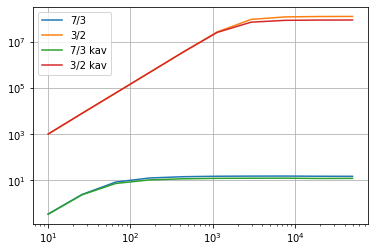

In [20]:
a0_grid = np.geomspace(1e1, 5e4, 10)*hs.r_isco
DE_df_73 = get_DE_df(hs, m2, a0_grid, df_73)
DE_df_32 = get_DE_df(hs, m2, a0_grid, df_32)
DE_df_73_kav = get_DE_df(hs, m2, a0_grid, df_73_kav)
DE_df_32_kav = get_DE_df(hs, m2, a0_grid, df_32_kav)

plt.loglog(a0_grid/hs.r_isco, np.abs(DE_df_73 / spike_73.potentialEnergy(spike_73.r_spike)), label='7/3')
plt.loglog(a0_grid/hs.r_isco, np.abs(DE_df_32 / spike_32.potentialEnergy(spike_32.r_spike)), label='3/2')
plt.loglog(a0_grid/hs.r_isco, np.abs(DE_df_73_kav / spike_73.potentialEnergy(spike_73.r_spike)), label='7/3 kav')
plt.loglog(a0_grid/hs.r_isco, np.abs(DE_df_32_kav / spike_32.potentialEnergy(spike_32.r_spike)), label='3/2 kav')
plt.grid();
plt.legend()